# Bias base line

In [516]:
library(sdazar)
library(readxl)
library(lubridate)
library(stringr)
library(ggplot2)
library(patchwork)
library(ggrepel)
library(ggridges)
library(cobalt)
library(texreg)
source('utils/functions.R')

## Read administrative data 

In [517]:
# registro personas encuestadas
renc = data.table(read_excel('data/LISTA MUESTRA REGISTRO.xlsx', sheet=1))
setnames(renc, names(renc), tolower(names(renc)))

In [518]:
setnames(renc, c('folio', 'unidad', 'delito', 'mes egreso', 'tipo egreso'), 
        c('id', 'unidad', 'rdelito', 'mes_egreso', 'tegreso'))

In [519]:
renc[, condicional:=ifelse(tegreso %like% 'CONDICIONAL', 1, 0)]
renc[, cpf := ifelse(unidad %like% 'CPF', 1, 0)]

In [521]:
# registro no encuestadas
nores = data.table(read_excel('data/Datos de mujeres - Estudio Sociologia UC.xlsx', sheet=2))
setnames(nores, names(nores), tolower(names(nores)))
nores[, id := .I]

In [522]:
vars = c('id', 'fecha ingreso', 'fecha egreso', 'delito', 'extensión de condena', 
         'patio', 'unidad', 'n de condenas anteriores', 'año de nacimiento', 'edad al ingreso', 
         'comuna', 'estado civil', 'hijos (cantidad)', 'tipo egreso', 'razon de ausencia')

In [523]:
nores = nores[, vars, with=FALSE]

In [524]:
nvars = c('id', 'ingreso', 'fegreso', 'delito', 'condena', 
         'patio', 'unidad', 'ncondenas', 'nacimiento', 'edad_ingreso', 
         'comuna', 'estado_civil', 'nhijos', 'tegreso', 'razon')

In [525]:
setnames(nores, vars, nvars)

So the variables I would use are: 

- crime 
- unit
- number of sentences
- year born
- number of kids
- married
- kind of release

In [527]:
nores[, condicional:=ifelse(tegreso %like% 'CONDICIONAL', 1, 0)]
nores[, rechazo := ifelse(razon %like% 'RECHAZA', 1, 0)]

### Read Baseline

In [529]:
# read base line data
b = fread('data/170630 Base Reinserción Línea Base.csv')
setnames(b, names(b), tolower(names(b)))

In [530]:
#print(names(b))

In [531]:
vars = c('muestra', 'folio_2', 'p3_anio', 'p1', 'p5', 'p131', 'p13', 'p137')
nvars = c('muestra', 'id', 'nacimiento', 'edad', 'unidad', 'condena_anterior', 'nhijos', 'delito')
setnames(b, vars, nvars)

In [532]:
b = b[muestra==1]

In [533]:
length(b$id) == length(renc$id) # matched!

[1] TRUE

## Variable adjustments 

### married

In [534]:
b = assmis(b, list(c('p79', 'p60')), list(9))
b[, casada := pmax(p60, p79, na.rm=TRUE)][is.na(casada) & p49==0, casada:=0][is.na(casada), casada := 0]
prop.table(table(b$casada, useNA='ifany')) # lower proportion


   0    1 
0.92 0.08 

In [535]:
nores[, casada := ifelse(estado_civil=='Casada', 1, 0)]
prop.table(table(nores$casada, useNA='ifany'))


        0         1 
0.8846154 0.1153846 

### kids

In [536]:
table(b$nhijos, useNA='ifany')


 0  1  2  3  4  5  6  7  8  9 11 
24 51 47 45 27 10 13  5  1  1  1 

In [537]:
table(nores$nhijos, useNA='ifany')


 0  1  2  3  4  5  6  7  8 10 11 
 3 14  8  9  7  4  2  2  1  1  1 

### sentence before

In [538]:
nores[, condena_anterior := as.numeric(ncondenas>0)]
prop.table(table(nores$condena_anterior))


        0         1 
0.2884615 0.7115385 

In [539]:
b = assmis(b, list('condena_anterior'), list(9))
prop.table(table(b$condena_anterior))


        0         1 
0.2366071 0.7633929 

### year born

In [540]:
nores[, nac := as.numeric(nacimiento)]

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”

In [541]:
nores[is.na(nac), nac := year(ingreso)- as.numeric(edad_ingreso)]

In [542]:
summary(nores$nac, useNA = 'ifany')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1938    1973    1982    1980    1991    1996 

In [546]:
b = assmis(b, list('nacimiento'), list(9999))
b[, nac := as.numeric(nacimiento)]
b[, ent_fecha := as.Date(fecha, "%m/%d/%Y")]
b[is.na(nac), nac := year(ent_fecha) - as.numeric(edad)]

In [547]:
summary(b$nac)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1948    1974    1982    1980    1989    1997 

### unit

In [548]:
table(nores$unidad)


       CPF TALITA KUM 
        49          3 

In [549]:
nores[, cpf := ifelse(unidad=='CPF', 1, 0)]

In [550]:
summary(nores$cpf)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9423  1.0000  1.0000 

In [551]:
#b = assmis(b, list('unidad'), list(9))
#b[, cpf := ifelse(unidad==1, 1, 0)]
# summary(b$cpf)

In [552]:
setkey(renc, id)
setkey(b, id)

In [553]:
b[renc, cpf := i.cpf] # cool!

# type of release

In [554]:
table(nores$condicional, useNA='ifany')


 0  1 
41 11 

In [555]:
b[renc, condicional := condicional]

In [556]:
table(b$condicional)


  0   1 
156  69 

### crime

In [557]:
table(nores$delito)


        Asociación ilícita                    Estafas 
                         1                          1 
                 Homicidio                      Hurto 
                         1                          3 
              Hurto simple      Infracción Ley 17.336 
                        20                          1 
Lesiones graves gravísimas                 Ley 20.000 
                         1                         15 
              Microtráfico                Receptación 
                         1                          1 
        Robo con violencia  Robo en lugar no habitado 
                         1                          1 
         Robo por sorpresa      Sustracciones menores 
                         1                          1 
                   Tráfico 
                         3 

In [558]:
labels = sort(unique(nores$delito))

##### groups
1. Hurto
2. Otros delitos contra la propiedad
3. Delitos de drogas
4. Delitos contra las personas
5. Otro

In [559]:
codes = c(5,2,4,1,1,2,4,3,3,2,2,2,2,4,3)

In [560]:
nores[.(delito=labels, to=codes), on='delito', rdelito_g := i.to]

In [561]:
# classification
table(nores$delito,nores$rdelito_g, useNA = 'ifany')

                            
                              1  2  3  4  5
  Asociación ilícita          0  0  0  0  1
  Estafas                     0  1  0  0  0
  Homicidio                   0  0  0  1  0
  Hurto                       3  0  0  0  0
  Hurto simple               20  0  0  0  0
  Infracción Ley 17.336       0  1  0  0  0
  Lesiones graves gravísimas  0  0  0  1  0
  Ley 20.000                  0  0 15  0  0
  Microtráfico                0  0  1  0  0
  Receptación                 0  1  0  0  0
  Robo con violencia          0  1  0  0  0
  Robo en lugar no habitado   0  1  0  0  0
  Robo por sorpresa           0  1  0  0  0
  Sustracciones menores       0  0  0  1  0
  Tráfico                     0  0  3  0  0

In [562]:
# registro de encuestadas
labels = sort(unique(renc$rdelito))

In [563]:
schema = data.table(delitos = labels)

In [564]:
schema[delitos %like% 'HURTO|Hurto', codes := 1]
schema[delitos %like% 'HOMICIDIO|Homicidio|LESIONES LEVES|MALTRATO|AMENAZAS', codes := 4]
schema[delitos %like% 'ESTAFA|Estafa|ROBO|PROPIEDAD INTELECTUAL|RECEPTACION', codes := 2]
schema[delitos %like% 'MICROTRAFICO|TRAFICO', codes := 3]
schema[delitos %like% 'Ley Emilia|PORTE ILEGAL', codes := 5]

In [565]:
renc[.(rdelito=schema$delitos, to=schema$codes), on='rdelito', rdelito_g := i.to]

In [566]:
# datos encuesta
table(b$delito, useNA = 'ifany')


 1  2  3  5  7  8  9 10 11 12 13 15 16 17 18 19 22 24 99 
 3  4  5  1 85  1  9 11 11  1  4 37 44  1  3  1  1  2  1 

In [567]:
lookvar(b, 'p137')

[1] "p137_otro"

In [568]:
b[p137_otro %in% c('LEY EMILIA'), delito :=13]
b[p137_otro %in% c('PARRICIDIO'), delito :=24]

In [569]:
codes = c(2,2,2,2,1,2,2,2,2,4,4,3,3,2,2,4,2,5,99)
dcodes = sort(unique(b$delito))

In [570]:
length(codes) == length(dcodes)

[1] TRUE

In [571]:
b[.(delito=dcodes, to=codes), on='delito', rdelito:=i.to]

In [572]:
table(b$delito, b$rdelito)

    
      1  2  3  4  5 99
  1   0  3  0  0  0  0
  2   0  4  0  0  0  0
  3   0  5  0  0  0  0
  5   0  1  0  0  0  0
  7  85  0  0  0  0  0
  8   0  1  0  0  0  0
  9   0  9  0  0  0  0
  10  0 11  0  0  0  0
  11  0 11  0  0  0  0
  12  0  0  0  1  0  0
  13  0  0  0  5  0  0
  15  0  0 37  0  0  0
  16  0  0 44  0  0  0
  17  0  1  0  0  0  0
  18  0  3  0  0  0  0
  19  0  0  0  1  0  0
  22  0  1  0  0  0  0
  24  0  0  0  0  1  0
  99  0  0  0  0  0  1

In [573]:
setkey(b, id)
b[renc, rdelito_g := rdelito_g]
b[is.na(rdelito_g) & rdelito !=99, rdelito_g := rdelito]

In [574]:
table(b$rdelito_g, useNA = 'ifany')


   1    2    3    4    5 <NA> 
  80   52   80    9    3    1 

In [650]:
# b = assmis(b, list('rdelito'), list(99))
prop.table(table(b$rdelito_g))


         1          2          3          4          5 
0.35714286 0.23214286 0.35714286 0.04017857 0.01339286 

In [651]:
prop.table(table(nores$rdelito))


         1          2          3          4          5 
0.44230769 0.11538462 0.36538462 0.05769231 0.01923077 

# Model rejection

In [577]:
m1 = glm(rechazo ~  nac + casada + nhijos + cpf + condena_anterior, 
         family='binomial', data = nores)

In [578]:
m2 = glm(rechazo ~  nac + as.factor(rdelito_g), 
         family='binomial', data = nores)

In [579]:
print(screenreg(list(m1, m2)))


                       Model 1   Model 2  
------------------------------------------
(Intercept)             15.15      -51.76 
                       (58.16)     (49.50)
nac                     -0.01        0.03 
                        (0.03)      (0.02)
casada                   0.75             
                        (1.07)            
nhijos                  -0.14             
                        (0.17)            
cpf                      1.39             
                        (1.40)            
condena_anterior        -1.58 *           
                        (0.70)            
as.factor(rdelito_g)2                0.71 
                                    (0.94)
as.factor(rdelito_g)3                1.08 
                                    (0.73)
as.factor(rdelito_g)4                0.21 
                                    (1.34)
as.factor(rdelito_g)5              -14.82 
                                 (1455.40)
------------------------------------------
AIC       

# Differences between groups

In [581]:
# merge dataset

vars = c('id', 'cpf', 'nac', 'rdelito_g', 'condicional', 
         'casada', 'nhijos', 'condena_anterior')
b1 = b[, vars, with=FALSE][, sample := 1]
n1 = nores[, vars, with=FALSE][, sample := 0]

dat = rbind(b1, n1)

In [582]:
nrow(dat)

[1] 277

In [583]:
table(dat$sample)


  0   1 
 52 225 

In [585]:
getdummies(dat, 'rdelito_g')

[[1]]
[1] "rdelito_g_1" "rdelito_g_3" "rdelito_g_2" "rdelito_g_4" "rdelito_g_5"



In [586]:
vars = paste0('rdelito_g_', 1:5)
nvars = c('del_hurto', 'del_propiedad', 'del_drogas', 'del_personas', 'del_otro')
setnames(dat, vars, nvars)

In [587]:
covars = c('cpf', 'nac', 'nhijos', 'condicional', 'condena_anterior', 'casada', nvars)
df = as.data.frame(dat[, covars, with=FALSE])
d = as.data.frame(rbm(df, as.factor(dat$sample)))

## Balance

In [588]:
d$labels = c('CPF', 'Año nacimiento', 'Num hijos', 'Libertad condicional', 
             'Condena anterior', 'Casada', 'Hurto', 'Delito propiedad', 'Delito drogas', 
            'Delito personas', 'Delito otro')

d$ind = as.numeric(abs(d$B) > .1)

In [589]:
plt = ggplot(d, aes(x=B, y=R, color=factor(ind))) + geom_point() +
    xlim(range(c(d$B[is.finite(d$B)], -1, 1))) +
    ylim(range(c(d$R[is.finite(d$R)], 0.1, 2))) + 
 geom_vline(xintercept = c(-0.1, 0.1), size=0.5, color='gray', linetype=3) + 
 geom_hline(yintercept = c(4/5, 5/4), size=0.5, color='gray', linetype=3) + 
 geom_text_repel(aes(B, R, label = labels), size=3) + 
 scale_color_manual(values=c('black', '#f03b20')) +
 labs(x='\nStandardized difference in means', y='Variance ratio\n') +  
 theme_classic() + theme(legend.position='none')

In [590]:
savepdf('plots/balance')
print(plt)
dev.off()

pdf 
  2

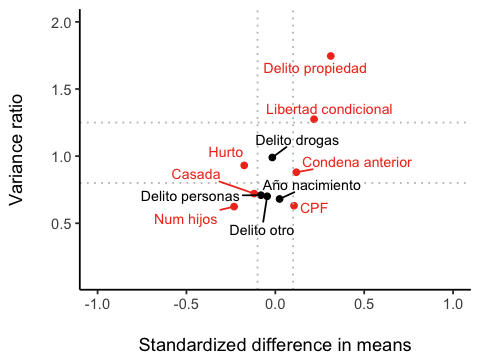

In [591]:
options(repr.plot.width = 4, repr.plot.height = 3)
plt

In [639]:
bal.tab(df[, c('condicional', 'nac', 'nhijos', 'condena_anterior', 'casada', 
              'del_propiedad', 'del_hurto')], treat=dat$sample, un=TRUE, 
        M.threshold='0.1', disp.means = TRUE, binary='raw', 
        s.d.denom='pooled', 
        disp.v.ratio=TRUE
       )

Balance Measures:
                         Type    M.0.Un    M.1.Un Diff.Un V.Ratio.Un
condicional            Binary    0.2115    0.3067  0.0951           
nac                   Contin. 1979.5000 1979.7956  0.0239     1.4909
nhijos                Contin.    3.0769    2.5733 -0.2304     1.6258
condena_anterior       Binary    0.7115    0.7634  0.0519           
condena_anterior:<NA>  Binary    0.0000    0.0044  0.0044           
casada                 Binary    0.1154    0.0800 -0.0354           
del_propiedad          Binary    0.1154    0.2321  0.1168           
del_propiedad:<NA>     Binary    0.0000    0.0044  0.0044           
del_hurto              Binary    0.4423    0.3571 -0.0852           

Sample sizes:
    Control Treated
All      52     225

# Standardized and relative bias

In [593]:
table(dat$sample)


  0   1 
 52 225 

In [594]:
# observed

ind = dat$sample

In [595]:
rs = dat[sample==1, covars, with=FALSE][, apply(.SD, 2, Mean)]
rp = dat[, covars, with=FALSE][, apply(.SD, 2, Mean)]

In [596]:
obs_r = (rs-rp)/rp

In [597]:
print(obs_r)

             cpf              nac           nhijos      condicional 
    4.327485e-03     2.802557e-05    -3.543527e-02     6.183333e-02 
condena_anterior           casada        del_hurto    del_propiedad 
    1.296360e-02    -7.666667e-02    -4.299584e-02     1.046798e-01 
      del_drogas     del_personas         del_otro 
   -4.329004e-03    -7.589286e-02    -7.589286e-02 


In [598]:
srd = dat[, covars, with=FALSE][, lapply(.SD, scale)]
ind = dat$sample == 1
srs = srd[ind,apply(.SD, 2, Mean)]
srp = srd[,apply(.SD, 2, Mean)]

In [599]:
obs_s = (srs - srp)

In [600]:
print(obs_s)

             cpf              nac           nhijos      condicional 
     0.021241968      0.004793208     -0.046774321      0.039332287 
condena_anterior           casada        del_hurto    del_propiedad 
     0.022631566     -0.023570381     -0.033115689      0.053896486 
      del_drogas     del_personas         del_otro 
    -0.003231698     -0.016151073     -0.009186673 


In [601]:
nrow(dat)

[1] 277

In [602]:
relbias = NULL
stdbias = NULL
for (i in 1:1000) { 
    ind = sample(nrow(dat), 225)
    
    rs = dat[ind, covars, with=FALSE][, apply(.SD, 2, Mean)]
    rp = dat[, covars, with=FALSE][, apply(.SD, 2, Mean)]
    
    srd = dat[, covars, with=FALSE][, lapply(.SD, scale)]
    srs = srd[ind,apply(.SD, 2, Mean)]
    srp = srd[,apply(.SD, 2, Mean)]
    
    s = (srs - srp)
    r = (rs-rp)/rp
    
    stdbias = rbind(stdbias, s)
    relbias = rbind(relbias, r)
    }

stdbias = as.data.table(stdbias)
relbias = as.data.table(relbias)

## Relative bias

In [603]:
covars = names(obs_r)

In [604]:
print(obs_r)

             cpf              nac           nhijos      condicional 
    4.327485e-03     2.802557e-05    -3.543527e-02     6.183333e-02 
condena_anterior           casada        del_hurto    del_propiedad 
    1.296360e-02    -7.666667e-02    -4.299584e-02     1.046798e-01 
      del_drogas     del_personas         del_otro 
   -4.329004e-03    -7.589286e-02    -7.589286e-02 


In [605]:
labels = c('CPF', 'Año nacimiento', 'Num hijos', 'Libertad condicional', 
             'Condena anterior', 'Casada', 'Hurto', 'Delito propiedad', 'Delito drogas', 
            'Delito personas', 'Delito otro')

In [606]:
for (i in seq_along(covars)) {     
    assign(paste0('plot_', i), ggplot(relbias, aes_string(x=covars[i])) +
          geom_density(color='white', alpha='0.3', fill='blue') +
          labs(y='', x= labels[i]) +
          geom_vline(xintercept = as.numeric(obs_r[covars[i]]), color='red', size=0.5, linetype=2) + 
          theme_classic())
}

In [607]:
options(repr.plot.width = 6, repr.plot.height = 8)
savepdf('plots/relative_bias', 16, 20)
eval(parse(text=paste0(paste0('plot_', seq_along(covars), collapse='+'), 
                       '+ plot_layout(ncol = 2)')))
dev.off()

pdf 
  2

# standardized bias

In [608]:
for (i in seq_along(covars)) {     
    assign(paste0('plot_', i), ggplot(stdbias, aes_string(x=covars[i])) +
          geom_density(color='white', alpha='0.3', fill='blue') +
         labs(y='', x= labels[i]) +
          geom_vline(xintercept = as.numeric(obs_s[covars[i]]), color='red', size=0.5, linetype=2) + 
          theme_classic())
}

In [609]:
options(repr.plot.width = 6, repr.plot.height = 8)
savepdf('plots/standardized_bias', 16, 20)
eval(parse(text=paste0(paste0('plot_', seq_along(covars), collapse='+'), 
                       '+ plot_layout(ncol = 2)')))
dev.off()

pdf 
  2

# Computing weights

In [610]:
library(ranger)

In [611]:
print(names(dat))

 [1] "id"               "cpf"              "nac"              "rdelito_g"       
 [5] "condicional"      "casada"           "nhijos"           "condena_anterior"
 [9] "sample"           "del_hurto"        "del_drogas"       "del_propiedad"   
[13] "del_personas"     "del_otro"        


In [612]:
print(countmis(dat))

       rdelito_g condena_anterior        del_hurto       del_drogas 
           0.004            0.004            0.004            0.004 
   del_propiedad     del_personas         del_otro 
           0.004            0.004            0.004 


In [613]:
dat[is.na(cpf), cpf:=1]
dat[is.na(condena_anterior), condena_anterior:= 1]
dat[is.na(del_propiedad), del_propiedad:=0]
dat[is.na(del_drogas), del_drogas:=0]
dat[is.na(del_personas), del_personas:=0]
dat[is.na(del_otro), del_otro:=0]
dat[is.na(del_hurto), del_hurto:=0]

In [614]:
m = ranger(sample ~ nac + casada + nhijos + casada + condena_anterior + del_propiedad + + del_drogas + 
           del_personas + del_otro +  cpf,
           num.trees=1000,
           importance='permutation',
            data = dat)

In [615]:
print(sort(m$variable.importance, decreasing=TRUE))

condena_anterior              nac       del_drogas           nhijos 
    0.0040810505     0.0040140458     0.0032689004     0.0026831945 
    del_personas    del_propiedad         del_otro           casada 
    0.0023766339     0.0018696934    -0.0004831252    -0.0009984201 
             cpf 
   -0.0017918984 


In [616]:
probs = m$predictions

In [617]:
summary(probs)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3980  0.7530  0.8347  0.8105  0.8892  0.9634 

In [618]:
weights = 1 / probs

In [619]:
dat[, w := weights]

In [620]:
dat[sample==0, w := NA]

In [621]:
dat[, w := w / (sum(w, na.rm=TRUE)/sum(sample))]

In [622]:
sum(dat$w, na.rm=TRUE)

[1] 225

In [623]:
# using weights

In [624]:
rs = dat[sample==1, c(covars, 'w'), with=FALSE][, apply(.SD, 2, weighted.mean, w=w)]
rs = rs[-length(rs)]
rp = dat[, covars, with=FALSE][, apply(.SD, 2, Mean)]
obs_r = (rs-rp)/rp

In [625]:
for (i in seq_along(covars)) {     
    assign(paste0('plot_', i), ggplot(relbias, aes_string(x=covars[i])) +
          geom_density(color='white', alpha='0.3', fill='blue') +
          labs(y='', x= labels[i]) +
          geom_vline(xintercept = as.numeric(obs_r[covars[i]]), color='red', size=0.5, linetype=2) + 
          theme_classic())
}

In [626]:
options(repr.plot.width = 6, repr.plot.height = 8)
savepdf('plots/relative_bias_w', 16, 20)
eval(parse(text=paste0(paste0('plot_', seq_along(covars), collapse='+'), 
                       '+ plot_layout(ncol = 2)')))
dev.off()

pdf 
  2

In [627]:
srd = dat[, c(covars), with=FALSE][, lapply(.SD, scale)]
ind = dat$sample == 1

srd[, w := dat$w]

In [628]:
srs = srd[ind,apply(.SD, 2, weighted.mean, w=w)]
srs = srs[-length(srs)]

In [629]:
srp = srd[,apply(.SD, 2, Mean)]

srp = srp[-length(srp)]

In [630]:
obs_s = (srs - srp)

In [631]:
for (i in seq_along(covars)) {     
    assign(paste0('plot_', i), ggplot(stdbias, aes_string(x=covars[i])) +
          geom_density(color='white', alpha='0.3', fill='blue') +
         labs(y='', x= labels[i]) +
          geom_vline(xintercept = as.numeric(obs_s[covars[i]]), color='red', size=0.5, linetype=2) + 
          theme_classic())
}

In [632]:
options(repr.plot.width = 6, repr.plot.height = 8)
savepdf('plots/standardized_bias_w', 16, 20)
eval(parse(text=paste0(paste0('plot_', seq_along(covars), collapse='+'), 
                       '+ plot_layout(ncol = 2)')))
dev.off()

pdf 
  2